In [1]:
using SparseArrays
using LinearAlgebra

# parameters
σ = 2.0 #1.2 #2.0   # CRRA utility with parameter s
# r = -0.05 #0.035 #0.03  # interest rate
ρ = 0.05  # discount rate
z1 = .1
z2 = .2
z = [z1 z2]
λ1 = 1.2 #0.02 # arrival rate when z=z1
λ2 = 1.2 #0.03 # arrival rate when z=z2
λ = [λ1 λ2]

# number of grid points
na = 1000
# set up the grid
amin = -0.15
amax = 5.0
a = collect(range(amin,stop=amax,length=na))
# distance between each grid
da = (amax-amin)/(na-1)

maxit = 20000 # maximum number of iterations
crit  = 1e-6; # convergence criteria

In [2]:
function vfict_implicit(v0,a,z,σ,ρ,maxit,crit,Delta)

    na = size(a,1)
    amin = minimum(a)
    amax = maximum(a)
    da = (amax-amin)/(na-1)
    
    # for iteration
    dVf = zeros(na,2) # forward difference
    dVb = zeros(na,2) # backward difference
    c   = zeros(na,2) # optimal consumption (from dV)
    AT  = zeros(2*na,2*na)

    # (na,nz) matrix
    aa = [a a]
    zz = ones(na,1)*z

    Aswitch = [-sparse(I,na,na)*λ[1] sparse(I,na,na)*λ[1]; sparse(I,na,na)*λ[2] -sparse(I,na,na)*λ[2]]

    v = v0 # new v
    V = v  # old v

    dist  = zeros(maxit) # distance between old and new value functions at each iteration

    # MAIN LOOP
    for n in 1:maxit

        # forward difference
        dVf[1:na-1,:] = (V[2:na,:]-V[1:na-1,:])/da
    #     dVf[na,:] = (z .+ r.*amax).^(-σ) # state constraint, for stability with implicit method?
        dVf[na,:] = zeros(1,2) # will never be used (as s<0)
        # backward difference
        dVb[2:na,:] = (V[2:na,:]-V[1:na-1,:])/da
        dVb[1,:] = (z .+ r.*amin).^(-σ) # state constraint, for stability with implicit method?
    #     dVb[1] = zeros(1,2) # will never be used (as s>0)

        # consumption and savings with forward difference
        cf = dVf.^(-1/σ)
        sf = zz + r.*aa - cf
        # consumption and savings with backward difference
        cb = dVb.^(-1/σ)
        sb = zz + r.*aa - cb
        # consumption and derivative of value function at steady state (used for c only)
        c0  = zz + r.*aa
        dV0 = c0.^(-σ)

        # dV_upwind makes a choice of forward or backward differences based on
        # the sign of the drift    
        If = sf .> 0       # below steady state
        Ib = sb .< 0       # above steady state
        I0 = (1.0.-If.-Ib) # at steady state

        # make sure the right approximations are used at the boundaries
    #     # at ik = 1, s>0 -> f is used
    #     Ib[1] = 0 
    #     If[1] = 1
    #     # at ik = nk, s<0 -> b is used
        Ib[na,:] = ones(1,2)
        If[na,:] = zeros(1,2)

        dV_Upwind = dVf.*If + dVb.*Ib + dV0.*I0 # important to include third term    
        c = dV_Upwind.^(-1.0/σ)
        u = c.^(1.0-σ)/(1.0-σ)

        # CONSTRUCT MATRIX
        X = -sb.*Ib/da
        Y = -sf.*If/da + sb.*Ib/da
        Z = sf.*If/da

        A1 = spdiagm(na,na,[0 => Y[1:na,1]]...) + spdiagm(na,na,[-1 => X[2:na,1]]...) + spdiagm(na,na,[1 => Z[1:na-1,1]]...)
        A2 = spdiagm(na,na,[0 => Y[1:na,2]]...) + spdiagm(na,na,[-1 => X[2:na,2]]...) + spdiagm(na,na,[1 => Z[1:na-1,2]]...)
        A = [A1 spzeros(na,na); spzeros(na,na) A2] + Aswitch

        # implicit method, with sparse matrix
        B = (Delta*ρ + 1.0)*sparse(1.0I, 2*na, 2*na) - Delta*A
        u_stacked = [u[:,1]; u[:,2]]
        V_stacked = [V[:,1]; V[:,2]]
        b = Delta*u_stacked + V_stacked
        v_stacked = B\b # new v
        v = [v_stacked[1:na] v_stacked[na+1:2*na]]
        Vchange = V - v
        V = v

        dist[n] = maximum(abs.(Vchange))
#         if (mod(n,10)==0)
#             println([n,dist[n]])
#         end
        if dist[n]<crit
#             println("Value Function Converged, Iteration = ")
#             println(n)
            AT = A'
            break
        end
    end
    
    return v, c, AT
    
end

vfict_implicit (generic function with 1 method)

In [3]:
function fokker_planck(AT)

    # fokker-planck equation
    # AT = A'
    na = Int(size(AT,1)/2)
    
    b = zeros(2*na,1)

    # need to fix one value, otherwise matrix is singular
    i_fix = 1
    b[i_fix] = .1
    row = [zeros(1,i_fix-1) 1 zeros(1,2*na-i_fix)]
    AT[i_fix,:] = row

    # Solve linear system
    gg = AT\b
    g_sum = gg'*ones(2*na,1)*da
    gg = gg./g_sum

    g = [gg[1:na] gg[na+1:2*na]]
    

    return g
    
end

fokker_planck (generic function with 1 method)

In [4]:
r0 = 0.03

# INITIAL GUESS
# v0 = (A.*k.^α).^(1.0-σ)/(1.0-σ)/ρ
v0 = zeros(na,2)
r = r0 # 0.01
v0[:,1] = (z[1] .+ r.*a).^(1.0-σ)/(1.0-σ)/ρ
v0[:,2] = (z[2] .+ r.*a).^(1.0-σ)/(1.0-σ)/ρ

Delta = 1000
# @time v,c,AT = vfict_implicit(v0,a,z,σ,ρ,maxit,crit,Delta);
# @time g = fokker_planck(AT);

In [5]:
nr = 40
rmin = 0.01
rmax = 0.04
S = zeros(nr)
crit_S = 1e-5
c = zeros(na,2)
g = zeros(na,2)

for ir in 1:nr
    
    @time v0,c,AT = vfict_implicit(v0,a,z,σ,ρ,maxit,crit,Delta);
    @time g = fokker_planck(AT);    
    S[ir] = g[:,1]'*a*da + g[:,2]'*a*da
    
    # UPDATE INTEREST RATE
    if S[ir]>crit_S
        println("Excess Supply")
        rmax = r
        r = 0.5*(r+rmin)
    elseif S[ir]<-crit_S
        println("Excess Demand")
        rmin = r
        r = 0.5*(r+rmax)
    elseif abs(S[ir])<crit_S
        println("Equilibrium Found, Interest rate = ")
        println(r)
        break
    end    

end

  7.008981 seconds (16.56 M allocations: 1003.887 MiB, 5.87% gc time, 98.89% compilation time)
  1.081526 seconds (2.74 M allocations: 159.837 MiB, 2.98% gc time, 99.73% compilation time)
Excess Demand
  0.036202 seconds (2.61 k allocations: 52.125 MiB, 24.53% gc time)
  0.002687 seconds (107 allocations: 2.165 MiB)
Excess Supply
  0.033927 seconds (2.62 k allocations: 52.109 MiB, 21.88% gc time)
  0.002127 seconds (107 allocations: 2.159 MiB)
Excess Demand
  0.027514 seconds (2.62 k allocations: 52.116 MiB, 17.99% gc time)
  0.002042 seconds (107 allocations: 2.162 MiB)
Excess Demand
  0.025838 seconds (2.62 k allocations: 52.123 MiB, 15.63% gc time)
  0.001941 seconds (107 allocations: 2.163 MiB)
Excess Supply
  0.021223 seconds (2.12 k allocations: 47.929 MiB, 12.29% gc time)
  0.001880 seconds (107 allocations: 2.162 MiB)
Excess Supply
  0.054290 seconds (2.12 k allocations: 47.928 MiB, 10.46% gc time)
  0.004982 seconds (107 allocations: 2.162 MiB)
Excess Demand
  0.049546 seconds

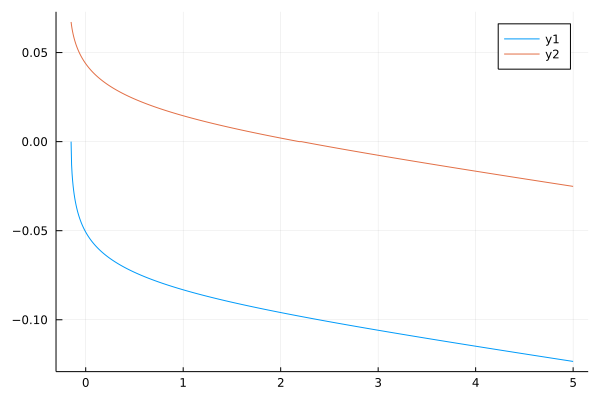

In [6]:
using Plots
# (na,nz) matrix
aa = [a a]
zz = ones(na,1)*z
adot = zz + r.*aa - c
plot(aa,adot)

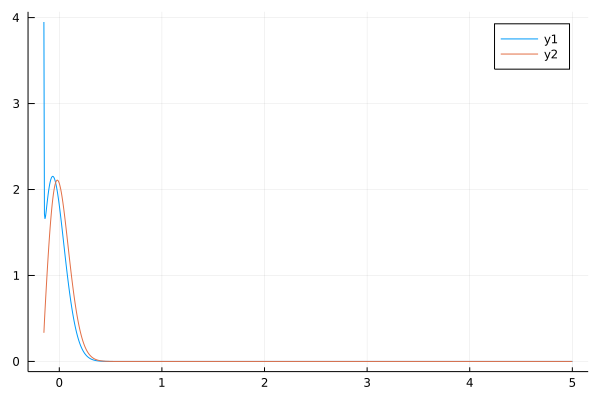

In [7]:
plot(aa,g)